# **Imports and Seeds**


In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import matplotlib.pyplot as plt
import random
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib
import shutil

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

# Configure GPU and TF behavior
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU is available: {gpus}")
    except RuntimeError as e:
        print(e)

# Disable GPU if causing issues
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Define paths
BASE_PATH = '/content/drive/MyDrive/Your_CW_Folder'
# Create a new folder for models
MODEL_PATH = '/content/Face_Mask_Models'
os.makedirs(MODEL_PATH, exist_ok=True)

# Dataset paths
TRAIN_IMG_PATH = '/content/drive/MyDrive/Your_CW_Folder/CW_Dataset/Dataset/train/images'
TRAIN_LABEL_PATH = '/content/drive/MyDrive/Your_CW_Folder/CW_Dataset/Dataset/train/labels'
TEST_IMG_PATH = '/content/drive/MyDrive/Your_CW_Folder/CW_Dataset/Dataset/test/images'
TEST_LABEL_PATH = '/content/drive/MyDrive/Your_CW_Folder/CW_Dataset/Dataset/test/labels'
PERSONAL_DATASET_PATH = '/content/drive/MyDrive/Your_CW_Folder/Personal Data'

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Data Loading Functions**


In [56]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def load_dataset(img_dir, lbl_dir, resize=(64, 64), max_samples=None):
    """
    Load dataset with parallel processing for faster execution.

    Args:
        img_dir: Directory containing images
        lbl_dir: Directory containing label files
        resize: Tuple of (width, height) for resizing images
        max_samples: Maximum number of samples to process (optional)

    Returns:
        np.array(X): Array of grayscale images
        np.array(y): Array of labels
    """
    X, y = [], []

    # Get list of image files
    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpeg', '.png'))])
    if max_samples:
        image_files = image_files[:max_samples]

    print(f"Processing {len(image_files)} images...")

    def process_file(fname):
        """Helper function to process a single image and label file."""
        try:
            img_path = os.path.join(img_dir, fname)
            lbl_path = os.path.join(lbl_dir, fname.replace('.jpeg', '.txt').replace('.png', '.txt'))

            # Read and process image
            img = cv2.imread(img_path)
            if img is None:
                return None, None

            img = cv2.resize(img, resize)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Read label
            with open(lbl_path, 'r') as f:
                label = int(f.read().strip())

            if label not in [0, 1, 2]:
                return None, None

            return img_gray, label
        except Exception as e:
            print(f"Error processing {fname}: {str(e)}")
            return None, None

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_file, image_files), total=len(image_files), desc="Loading images"))

    # Filter out None results and collect valid data
    for img, label in results:
        if img is not None and label is not None:
            X.append(img)
            y.append(label)

    print(f"Loaded {len(X)} valid images.")
    return np.array(X), np.array(y)

# **Feature Extraction and Model Training Functions**

In [57]:
def extract_hog_features(images):
    features = []
    for image in images:
        feat = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        features.append(feat)
    return np.array(features)

def train_hog_svm(X_train, y_train):
    print("[INFO] Extracting HOG features for SVM...")
    X_train_hog = extract_hog_features(X_train)

    # Use StandardScaler for better performance
    scaler = StandardScaler()
    X_train_hog = scaler.fit_transform(X_train_hog)

    # Simplified parameter grid for faster training
    param_grid = {
        'C': [1, 10],
        'kernel': ['rbf']
    }

    svm = SVC(probability=True)
    grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_hog, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_, scaler

def train_hog_mlp(X_train, y_train):
    print("[INFO] Extracting HOG features for MLP...")
    features = extract_hog_features(X_train)

    # Use StandardScaler
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Simplified MLP architecture
    model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100)
    model.fit(features, y_train)
    return model, scaler

def train_cnn(X_train, y_train, X_val, y_val):
    # Prepare data
    X_train = X_train.reshape(-1, 64, 64, 1) / 255.0
    X_val = X_val.reshape(-1, 64, 64, 1) / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, 3)
    y_val = tf.keras.utils.to_categorical(y_val, 3)

    # Modified CNN architecture without MaxPooling
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2)),  # Replace MaxPool with stride
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=(2, 2)),  # Replace MaxPool with stride
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Configure GPU settings
    tf.config.set_soft_device_placement(True)
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(X_val, y_val),
                       callbacks=[early_stopping],
                       verbose=1)
    return model, history

In [58]:
def train_ensemble(models, models_scaler, X_test):
    """
    Combine predictions from multiple models using majority voting.

    Args:
        models: Dictionary of trained models (HOG+SVM, HOG+MLP, CNN)
        models_scaler: Dictionary of scalers for each model
        X_test: Test data

    Returns:
        y_pred_ensemble: Ensemble predictions
    """
    # Initialize arrays to store predictions
    svm_model = models["HOG + SVM"]
    mlp_model = models["HOG + MLP"]
    cnn_model = models["CNN"]
    svm_scaler = models_scaler["HOG + SVM"]
    mlp_scaler = models_scaler["HOG + MLP"]

    # Extract HOG features for SVM and MLP
    X_test_hog = extract_hog_features(X_test)

    # SVM predictions
    X_test_hog_svm = svm_scaler.transform(X_test_hog)
    svm_pred = svm_model.predict(X_test_hog_svm)

    # MLP predictions
    X_test_hog_mlp = mlp_scaler.transform(X_test_hog)
    mlp_pred = mlp_model.predict(X_test_hog_mlp)

    # CNN predictions
    X_test_cnn = X_test.reshape(-1, 64, 64, 1) / 255.0
    cnn_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

    # Combine predictions using majority voting
    y_pred_ensemble = []
    for i in range(len(X_test)):
        # Get predictions from all models for the current sample
        votes = [svm_pred[i], mlp_pred[i], cnn_pred[i]]
        # Use mode (most common prediction) as ensemble prediction
        ensemble_pred = max(set(votes), key=votes.count)
        y_pred_ensemble.append(ensemble_pred)

    return np.array(y_pred_ensemble)

# **Evaluation Functions**

In [59]:
def evaluate_model(model, X_test, y_test, model_name="Model", scaler=None):
    """Evaluate model performance."""
    if model_name != "CNN":
        X_test_hog = extract_hog_features(X_test)
        if scaler:
            X_test_hog = scaler.transform(X_test_hog)
        y_pred = model.predict(X_test_hog)
    else:
        # For CNN, reshape and normalize the input
        X_test_processed = X_test.reshape(-1, 64, 64, 1) / 255.0
        y_pred = np.argmax(model.predict(X_test_processed), axis=1)

    print(f"\n[{model_name}] Evaluation Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return accuracy_score(y_test, y_pred)

def visualize_predictions(model, X_test, y_test, model_name="Model", num_samples=5, scaler=None):
    indices = random.sample(range(len(X_test)), min(num_samples, len(X_test)))

    plt.figure(figsize=(15, 3*num_samples))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = y_test[idx]

        if model_name != "CNN":
            # Properly reshape the image for HOG feature extraction
            feat = hog(img.reshape(64, 64), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            if scaler:
                feat = scaler.transform(feat.reshape(1, -1))
            pred = model.predict(feat.reshape(1, -1))[0]
        else:
            pred = np.argmax(model.predict(img.reshape(1, 64, 64, 1) / 255.0)[0])

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True Label: {true_label}, Predicted: {pred}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def create_validation_split(X_train, y_train, val_size=0.2):
    """Create a validation split from the training data."""
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=val_size,
        random_state=SEED,
        stratify=y_train
    )
    return X_train, X_val, y_train, y_val

In [60]:
def ensemble_predict(img, models, models_scaler):
    """
    Generate ensemble prediction for a single image using majority voting.

    Args:
        img: Input image (grayscale, 64x64)
        models: Dictionary of trained models (HOG+SVM, HOG+MLP, CNN)
        models_scaler: Dictionary of scalers for each model

    Returns:
        pred: Ensemble prediction (0, 1, or 2)
    """
    svm_model = models["HOG + SVM"]
    mlp_model = models["HOG + MLP"]
    cnn_model = models["CNN"]
    svm_scaler = models_scaler["HOG + SVM"]
    mlp_scaler = models_scaler["HOG + MLP"]

    # Extract HOG features for SVM and MLP
    feat = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

    # SVM prediction
    feat_svm = svm_scaler.transform(feat.reshape(1, -1))
    svm_pred = svm_model.predict(feat_svm)[0]

    # MLP prediction
    feat_mlp = mlp_scaler.transform(feat.reshape(1, -1))
    mlp_pred = mlp_model.predict(feat_mlp)[0]

    # CNN prediction
    img_cnn = img.reshape(1, 64, 64, 1) / 255.0
    cnn_pred = np.argmax(cnn_model.predict(img_cnn)[0])

    # Majority voting
    votes = [svm_pred, mlp_pred, cnn_pred]
    pred = max(set(votes), key=votes.count)

    return pred

# **Visualization Functions**

In [61]:
def MaskDetection(model, path, model_type="CNN", scaler=None):
    """
    Visualize predictions on personal dataset images.

    Args:
        model: Trained model or callable for ensemble
        path: Path to directory containing test images
        model_type: Type of model ("CNN", "SVM", "MLP", "Ensemble")
        scaler: Scaler for feature normalization (for SVM and MLP)
    """
    image_files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if len(image_files) < 4:
        raise ValueError("Need at least 4 images in the directory")

    selected_images = random.sample(image_files, 4)
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image: {img_name}")
            continue

        img = cv2.resize(img, (64, 64))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if model_type == "CNN":
            img_input = img_gray.reshape(1, 64, 64, 1) / 255.0
            pred = np.argmax(model.predict(img_input)[0])
        elif model_type == "Ensemble":
            pred = model(img_gray)  # Callable for ensemble
        else:
            feat = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            if scaler:
                feat = scaler.transform(feat.reshape(1, -1))
            pred = model.predict(feat.reshape(1, -1))[0]

        label_map = {0: "No Mask", 1: "Mask", 2: "Improper Mask"}
        pred_label = label_map[pred]

        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    local_path = '/content/mask_detection_results.png'
    drive_path = os.path.join(MODEL_PATH, 'mask_detection_results.png')
    try:
        plt.savefig(local_path)
        print(f"Saved plot to local: {local_path}")
        shutil.copy(local_path, drive_path)
        print(f"Copied plot to Drive: {drive_path}")
    except Exception as e:
        print(f"Error saving plot: {str(e)}")
        print(f"Plot saved locally at: {local_path}")
    finally:
        plt.show()

def compare_models(models, X_test, y_test, model_names, models_scaler):
    """
    Compare models using various metrics and visualizations.

    Args:
        models: List of trained models
        X_test: Test data
        y_test: Test labels
        model_names: List of model names
        models_scaler: Dictionary of scalers for each model
    """
    results = {}

    for model, name in zip(models, model_names):
        start_time = time.time()

        if name == "CNN":
            X_test_processed = X_test.reshape(-1, 64, 64, 1) / 255.0
            y_pred = np.argmax(model.predict(X_test_processed), axis=1)
        else:
            X_test_hog = extract_hog_features(X_test)
            if name in models_scaler and models_scaler[name] is not None:
                X_test_hog = models_scaler[name].transform(X_test_hog)
            y_pred = model.predict(X_test_hog)

        inference_time = time.time() - start_time

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'inference_time': inference_time,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

    # Print comparison
    print("\nModel Comparison:")
    print("-" * 50)
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"Inference Time: {result['inference_time']:.4f} seconds")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'confusion_matrix_{name.replace(" + ", "_")}.png')
        plt.show()

    return results

def plot_performance_comparison(accuracies, inference_times, model_names):
    """
    Plot performance comparison between models.

    Args:
        accuracies: Dict of model accuracies
        inference_times: Dict of model inference times
        model_names: List of model names
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f1c40f']  # Added color for ensemble
    bars1 = ax1.bar(model_names, list(accuracies.values()), color=colors)
    ax1.set_ylabel('Accuracy Score')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylim([0, 1.0])
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')
    bars2 = ax2.bar(model_names, list(inference_times.values()), color=colors)
    ax2.set_ylabel('Inference Time (seconds)')
    ax2.set_title('Model Inference Time Comparison')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{height:.4f}s', ha='center', va='bottom')
    plt.tight_layout()
    local_path = '/content/model_comparison.png'
    drive_path = os.path.join(MODEL_PATH, 'model_comparison.png')
    try:
        plt.savefig(local_path)
        print(f"Saved plot to local: {local_path}")
        shutil.copy(local_path, drive_path)
        print(f"Copied plot to Drive: {drive_path}")
    except Exception as e:
        print(f"Error saving plot: {str(e)}")
        print(f"Plot saved locally at: {local_path}")
    finally:
        plt.show()

def plot_cnn_history(history):
    """
    Plot the training history of the CNN model.

    Args:
        history: History object from model.fit()
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    local_path = '/content/cnn_training_history.png'
    drive_path = os.path.join(MODEL_PATH, 'cnn_training_history.png')
    try:
        plt.savefig(local_path)
        print(f"Saved plot to local: {local_path}")
        shutil.copy(local_path, drive_path)
        print(f"Copied plot to Drive: {drive_path}")
    except Exception as e:
        print(f"Error saving plot: {str(e)}")
        print(f"Plot saved locally at: {local_path}")
    finally:
        plt.show()

def plot_class_distribution(y_train, y_test):
    """
    Plot class distribution in training and test sets.

    Args:
        y_train: Training labels
        y_test: Test labels
    """
    labels = ['No Mask', 'Mask', 'Improper Mask']

    plt.figure(figsize=(12, 5))

    # Count classes in training set
    train_counts = [np.sum(y_train == i) for i in range(3)]

    # Count classes in test set
    test_counts = [np.sum(y_test == i) for i in range(3)]

    # Plot training set distribution
    plt.subplot(1, 2, 1)
    plt.bar(labels, train_counts, color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Training Set Class Distribution')
    plt.ylabel('Number of Images')

    # Add counts above bars
    for i, count in enumerate(train_counts):
        plt.text(i, count + 5, str(count), ha='center', va='bottom')

    # Plot test set distribution
    plt.subplot(1, 2, 2)
    plt.bar(labels, test_counts, color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Test Set Class Distribution')
    plt.ylabel('Number of Images')

    # Add counts above bars
    for i, count in enumerate(test_counts):
        plt.text(i, count + 2, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()

# **Main Function**

In [65]:
def main():
    # Create Models directory if it doesn't exist
    os.makedirs(MODEL_PATH, exist_ok=True)
    print(f"[INFO] Models will be saved in: {MODEL_PATH}")

    # Load ALL data without max_samples limit
    print("[INFO] Loading training data...")
    X_train, y_train = load_dataset(TRAIN_IMG_PATH, TRAIN_LABEL_PATH)
    print("[INFO] Loading test data...")
    X_test, y_test = load_dataset(TEST_IMG_PATH, TEST_LABEL_PATH)

    # Plot class distribution
    print("[INFO] Plotting class distribution...")
    plot_class_distribution(y_train, y_test)

    # Create validation split
    print("[INFO] Creating validation split...")
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        random_state=SEED,
        stratify=y_train
    )

    # Initialize dictionaries to store model performance
    accuracies = {}
    inference_times = {}
    models = {}
    models_scaler = {}

    # Train and evaluate models
    print("\n[INFO] Training HOG + SVM model...")
    start_time = time.time()
    svm_model, svm_scaler = train_hog_svm(X_train, y_train)
    svm_train_time = time.time() - start_time
    print(f"SVM Training Time: {svm_train_time:.2f} seconds")

    print("[INFO] Evaluating SVM model...")
    start_time = time.time()
    svm_accuracy = evaluate_model(svm_model, X_test, y_test, "HOG + SVM", svm_scaler)
    svm_inference_time = time.time() - start_time

    models["HOG + SVM"] = svm_model
    models_scaler["HOG + SVM"] = svm_scaler
    accuracies["HOG + SVM"] = svm_accuracy
    inference_times["HOG + SVM"] = svm_inference_time

    print("\n[INFO] Training HOG + MLP model...")
    start_time = time.time()
    mlp_model, mlp_scaler = train_hog_mlp(X_train, y_train)
    mlp_train_time = time.time() - start_time
    print(f"MLP Training Time: {mlp_train_time:.2f} seconds")

    print("[INFO] Evaluating MLP model...")
    start_time = time.time()
    mlp_accuracy = evaluate_model(mlp_model, X_test, y_test, "HOG + MLP", mlp_scaler)
    mlp_inference_time = time.time() - start_time

    models["HOG + MLP"] = mlp_model
    models_scaler["HOG + MLP"] = mlp_scaler
    accuracies["HOG + MLP"] = mlp_accuracy
    inference_times["HOG + MLP"] = mlp_inference_time

    print("\n[INFO] Training CNN model...")
    start_time = time.time()
    cnn_model, history = train_cnn(X_train, y_train, X_val, y_val)
    cnn_train_time = time.time() - start_time
    print(f"CNN Training Time: {cnn_train_time:.2f} seconds")

    print("[INFO] Evaluating CNN model...")
    start_time = time.time()
    cnn_accuracy = evaluate_model(cnn_model, X_test, y_test, "CNN")
    cnn_inference_time = time.time() - start_time

    models["CNN"] = cnn_model
    models_scaler["CNN"] = None  # CNN doesn't need a scaler
    accuracies["CNN"] = cnn_accuracy
    inference_times["CNN"] = cnn_inference_time

    # Plot CNN training history
    print("[INFO] Plotting CNN training history...")
    plot_cnn_history(history)

    # Plot model performance comparison
    print("[INFO] Plotting model performance comparison...")
    plot_performance_comparison(accuracies, inference_times, list(models.keys()))

    # Save models with proper error handling
    print("\n[INFO] Saving models...")
    try:
        # Save to local storage first
        local_model_path = '/content/models'
        os.makedirs(local_model_path, exist_ok=True)

        # CNN model
        local_cnn_path = os.path.join(local_model_path, 'cnn_model.keras')
        cnn_path = os.path.join(MODEL_PATH, 'cnn_model.keras')
        try:
            cnn_model.save(local_cnn_path)
            shutil.copy(local_cnn_path, cnn_path)
            print(f"CNN model saved to: {cnn_path}")
        except Exception as e:
            print(f"Error saving CNN model: {str(e)}")
            print(f"CNN model saved locally at: {local_cnn_path}")

        # SVM model
        local_svm_path = os.path.join(local_model_path, 'svm_model.joblib')
        svm_path = os.path.join(MODEL_PATH, 'svm_model.joblib')
        try:
            joblib.dump(svm_model, local_svm_path)
            shutil.copy(local_svm_path, svm_path)
            print(f"SVM model saved to: {svm_path}")
        except Exception as e:
            print(f"Error saving SVM model: {str(e)}")
            print(f"SVM model saved locally at: {local_svm_path}")

        # SVM scaler
        local_svm_scaler_path = os.path.join(local_model_path, 'svm_scaler.joblib')
        svm_scaler_path = os.path.join(MODEL_PATH, 'svm_scaler.joblib')
        try:
            joblib.dump(svm_scaler, local_svm_scaler_path)
            shutil.copy(local_svm_scaler_path, svm_scaler_path)
            print(f"SVM scaler saved to: {svm_scaler_path}")
        except Exception as e:
            print(f"Error saving SVM scaler: {str(e)}")
            print(f"SVM scaler saved locally at: {local_svm_scaler_path}")

        # MLP model
        local_mlp_path = os.path.join(local_model_path, 'mlp_model.joblib')
        mlp_path = os.path.join(MODEL_PATH, 'mlp_model.joblib')
        try:
            joblib.dump(mlp_model, local_mlp_path)
            shutil.copy(local_mlp_path, mlp_path)
            print(f"MLP model saved to: {mlp_path}")
        except Exception as e:
            print(f"Error saving MLP model: {str(e)}")
            print(f"MLP model saved locally at: {local_mlp_path}")

        # MLP scaler
        local_mlp_scaler_path = os.path.join(local_model_path, 'mlp_scaler.joblib')
        mlp_scaler_path = os.path.join(MODEL_PATH, 'mlp_scaler.joblib')
        try:
            joblib.dump(mlp_scaler, local_mlp_scaler_path)
            shutil.copy(local_mlp_scaler_path, mlp_scaler_path)
            print(f"MLP scaler saved to: {mlp_scaler_path}")
        except Exception as e:
            print(f"Error saving MLP scaler: {str(e)}")
            print(f"MLP scaler saved locally at: {local_mlp_scaler_path}")

        print("\n[INFO] Verifying saved models...")
        try:
            saved_files = os.listdir(MODEL_PATH)
            print("Saved files:", saved_files)
        except Exception as e:
            print(f"Error listing saved models: {str(e)}")

    except Exception as e:
        print(f"Error during model saving: {str(e)}")

    # Ensemble Learning
    print("\n[INFO] Evaluating Ensemble model...")
    start_time = time.time()
    y_pred_ensemble = train_ensemble(models, models_scaler, X_test)
    ensemble_inference_time = time.time() - start_time

    # Evaluate ensemble predictions
    print("\n[Ensemble] Evaluation Results:")
    ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
    print("Accuracy:", ensemble_accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

    # Add ensemble to models dictionary for comparison
    models["Ensemble"] = None  # No actual model object, just for comparison
    models_scaler["Ensemble"] = None
    accuracies["Ensemble"] = ensemble_accuracy
    inference_times["Ensemble"] = ensemble_inference_time

    # Plot performance comparison including ensemble
    print("[INFO] Plotting performance comparison including ensemble...")
    plot_performance_comparison(accuracies, inference_times, list(models.keys()))

    return models, models_scaler

# **Main Execution**

[INFO] Models will be saved in: /content/Face_Mask_Models
[INFO] Loading training data...
Processing 2394 images...


Loading images: 100%|██████████| 2394/2394 [00:28<00:00, 82.77it/s] 


Loaded 2394 valid images.
[INFO] Loading test data...
Processing 458 images...


Loading images: 100%|██████████| 458/458 [00:02<00:00, 198.19it/s]


Loaded 458 valid images.
[INFO] Plotting class distribution...


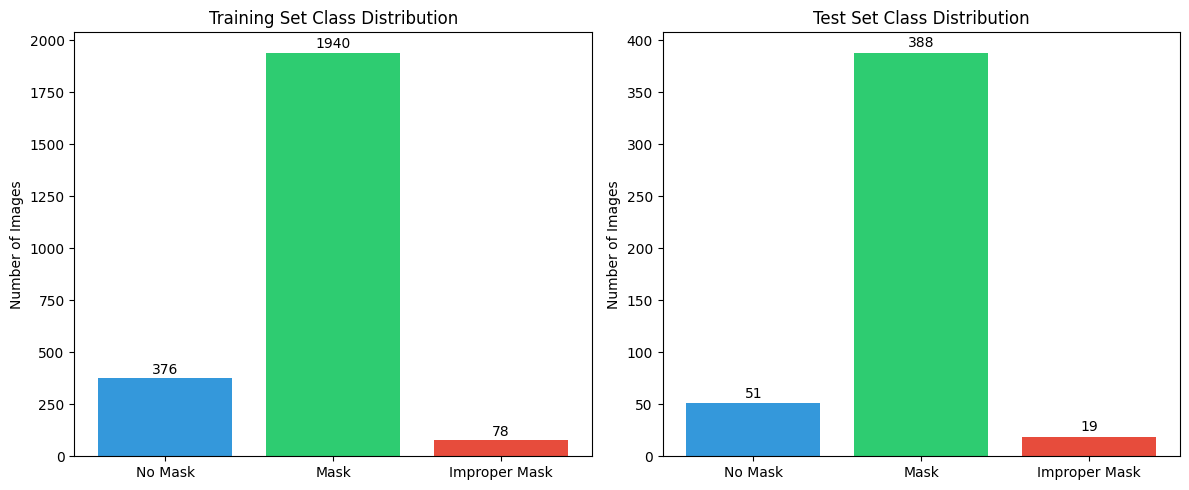

[INFO] Creating validation split...

[INFO] Training HOG + SVM model...
[INFO] Extracting HOG features for SVM...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'C': 10, 'kernel': 'rbf'}
SVM Training Time: 62.65 seconds
[INFO] Evaluating SVM model...

[HOG + SVM] Evaluation Results:
Accuracy: 0.8799126637554585
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.43      0.53        51
           1       0.89      0.98      0.93       388
           2       1.00      0.11      0.19        19

    accuracy                           0.88       458
   macro avg       0.86      0.50      0.55       458
weighted avg       0.88      0.88      0.86       458


[INFO] Training HOG + MLP model...
[INFO] Extracting HOG features for MLP...
MLP Training Time: 7.74 seconds
[INFO] Evaluating MLP model...

[HOG + MLP] Evaluation Results:
Accuracy: 0.8733624454148472
Classification Report:
               precision  

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7654 - loss: 0.6463 - val_accuracy: 0.7996 - val_loss: 0.5757
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8176 - loss: 0.4928 - val_accuracy: 0.8372 - val_loss: 0.6020
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8411 - loss: 0.4256 - val_accuracy: 0.8497 - val_loss: 0.4697
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8680 - loss: 0.3588 - val_accuracy: 0.8580 - val_loss: 0.4520
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8817 - loss: 0.3302 - val_accuracy: 0.8643 - val_loss: 0.4732
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8950 - loss: 0.2948 - val_accuracy: 0.8747 - val_loss: 0.4200
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9007 - loss: 0.2755 - val_accuracy: 0.8747 - val_loss: 0.4540
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9121 - loss: 0.2467 - val_accuracy: 0.8747 - val_loss: 0.4396

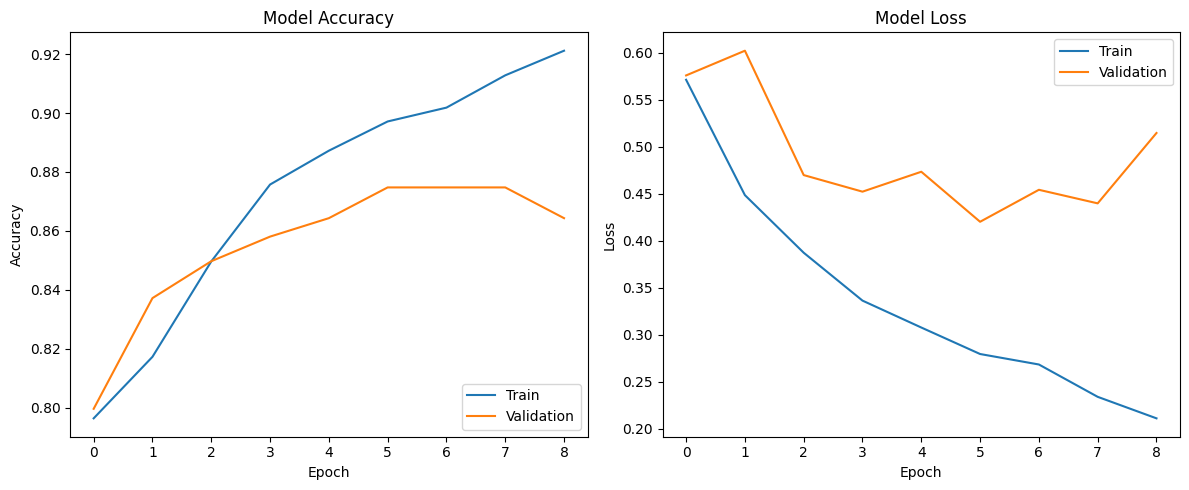

[INFO] Plotting model performance comparison...
Saved plot to local: /content/model_comparison.png
Copied plot to Drive: /content/Face_Mask_Models/model_comparison.png


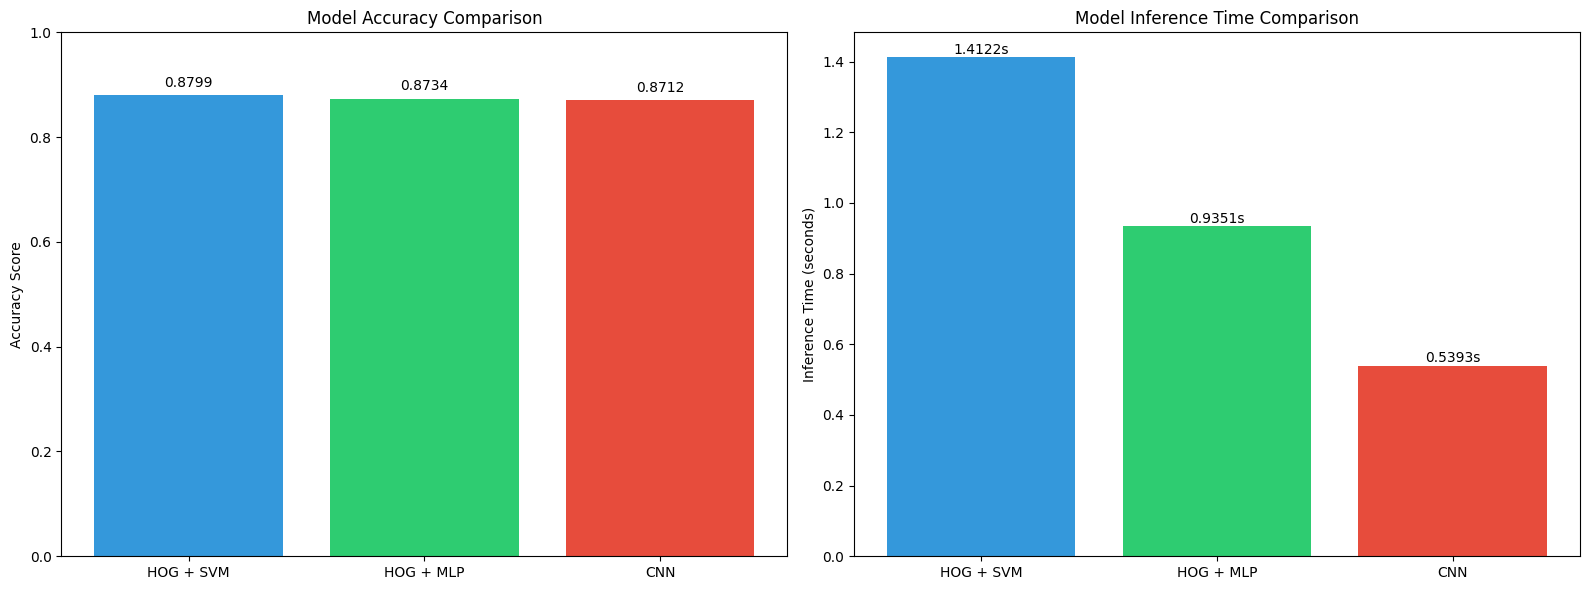


[INFO] Saving models...
CNN model saved to: /content/Face_Mask_Models/cnn_model.keras
SVM model saved to: /content/Face_Mask_Models/svm_model.joblib
SVM scaler saved to: /content/Face_Mask_Models/svm_scaler.joblib
MLP model saved to: /content/Face_Mask_Models/mlp_model.joblib
MLP scaler saved to: /content/Face_Mask_Models/mlp_scaler.joblib

[INFO] Verifying saved models...
Saved files: ['svm_scaler.joblib', 'cnn_model.keras', 'svm_model.joblib', 'mlp_scaler.joblib', 'mlp_model.joblib', 'model_comparison.png', 'cnn_training_history.png']

[INFO] Evaluating Ensemble model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

[Ensemble] Evaluation Results:
Accuracy: 0.8820960698689956
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.47      0.55        51
           1       0.90      0.97      0.94       388
           2       1.00      0.11      0.19        19

    accuracy                           0.88       458
   macro avg       0.8

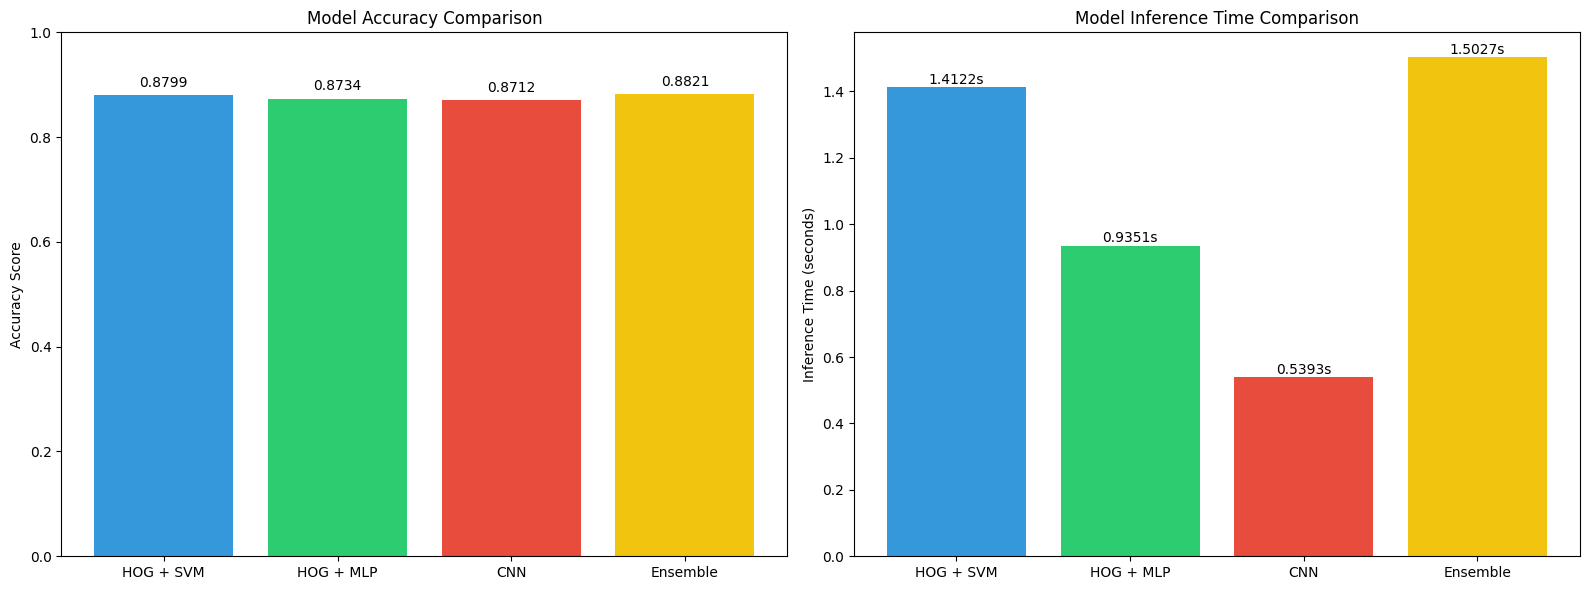


[INFO] Predicting on test images using MaskDetection...

[INFO] Testing CNN model on test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Saved plot to local: /content/mask_detection_results.png
Copied plot to Drive: /content/Face_Mask_Models/mask_detection_results.png


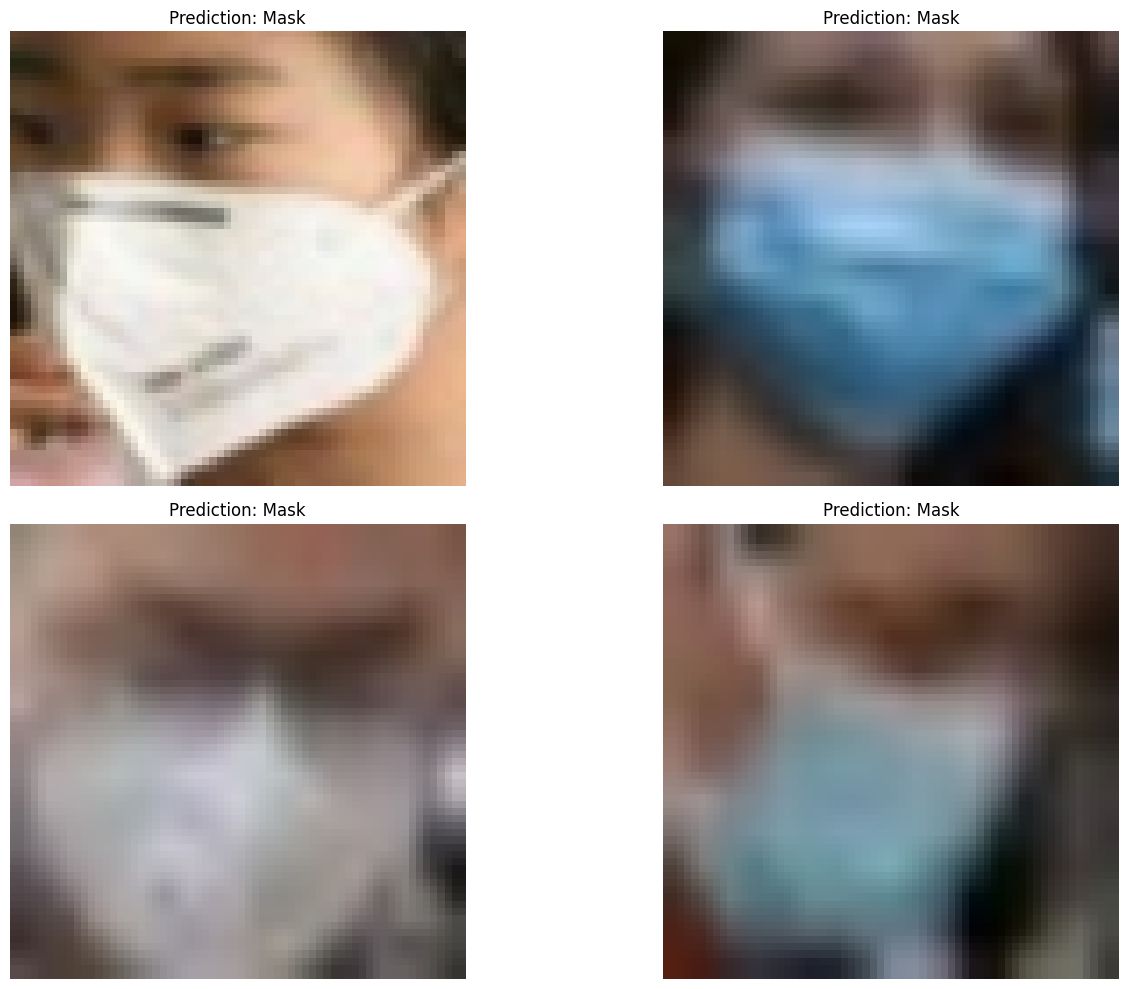


[INFO] Testing HOG + SVM model on test images...
Saved plot to local: /content/mask_detection_results.png
Copied plot to Drive: /content/Face_Mask_Models/mask_detection_results.png


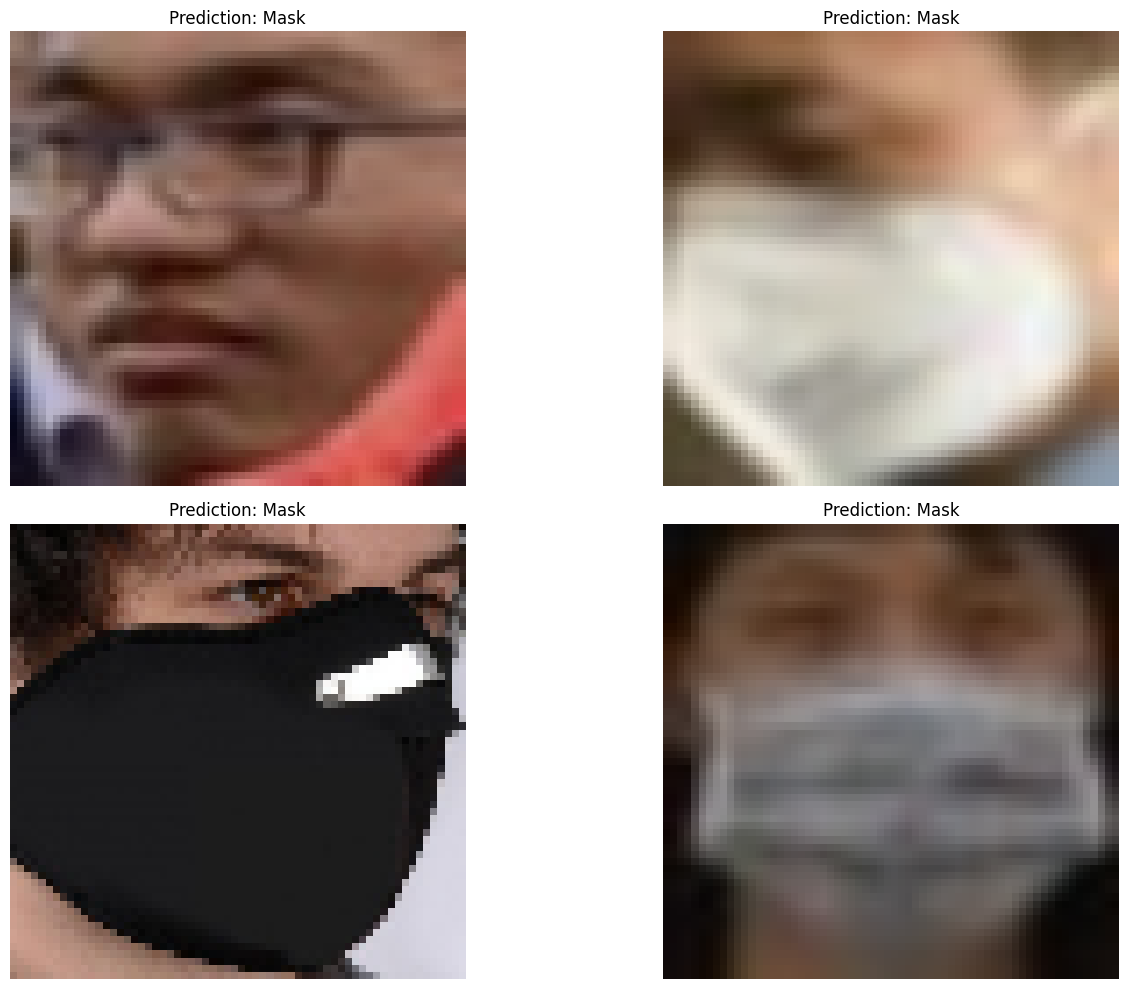


[INFO] Testing HOG + MLP model on test images...
Saved plot to local: /content/mask_detection_results.png
Copied plot to Drive: /content/Face_Mask_Models/mask_detection_results.png


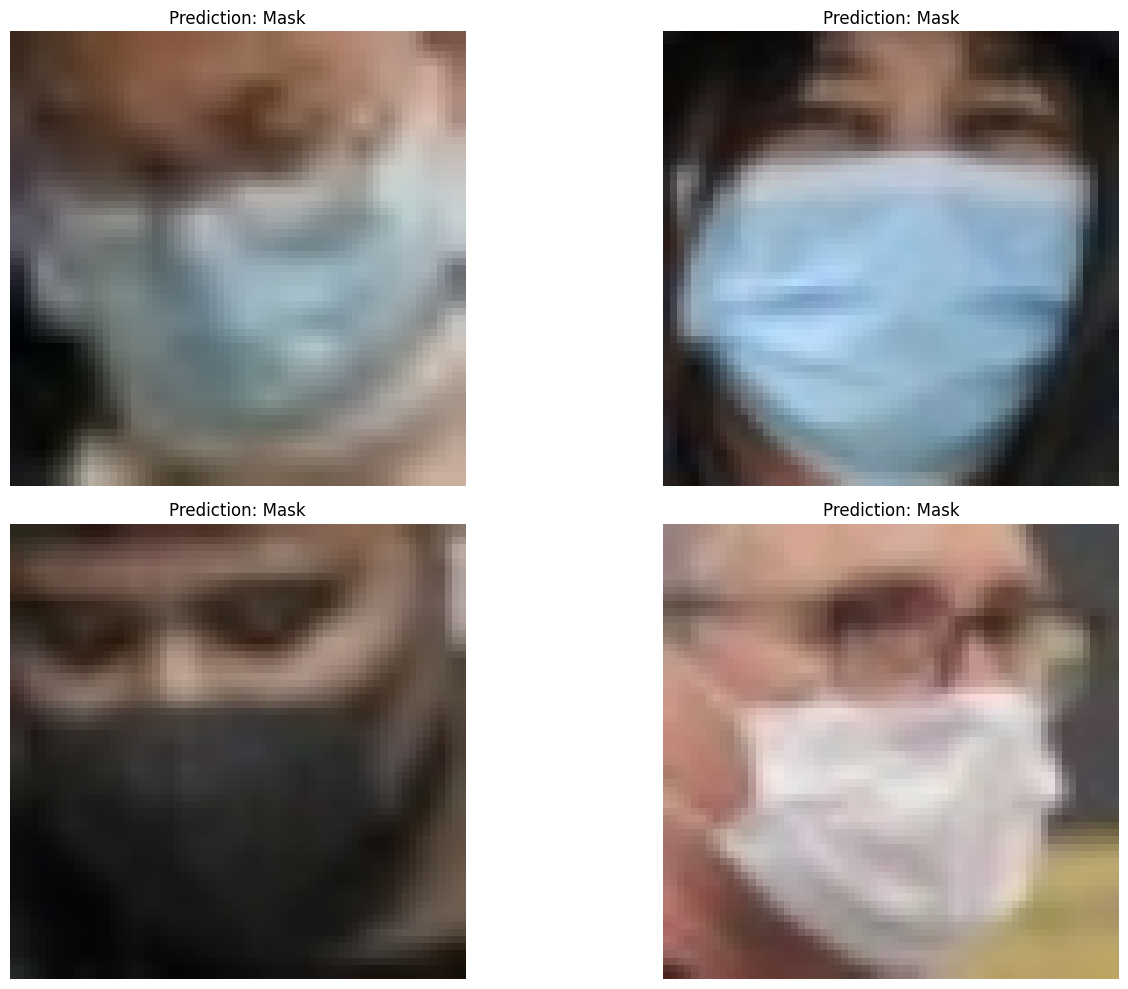


[INFO] Testing Ensemble model on test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Saved plot to local: /content/mask_detection_results.png
Copied plot to Drive: /content/Face_Mask_Models/mask_detection_results.png


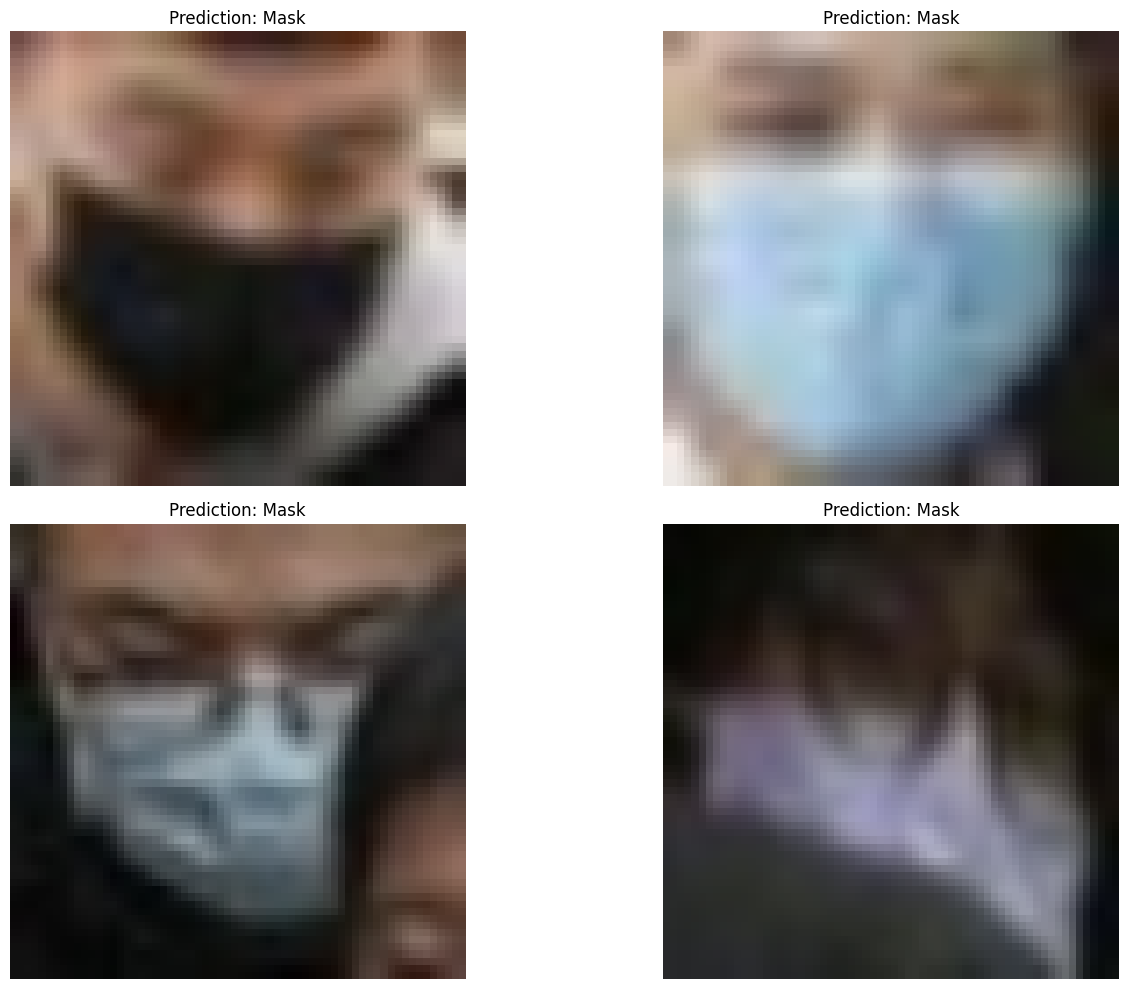

In [66]:
if __name__ == "__main__":
    # Run main training and evaluation
    try:
        models, models_scaler = main()
    except Exception as e:
        print(f"Error in main: {str(e)}")
        raise

    # Predict on test images using MaskDetection
    print("\n[INFO] Predicting on test images using MaskDetection...")
    try:
        # Test with CNN
        print("\n[INFO] Testing CNN model on test images...")
        MaskDetection(models["CNN"], TEST_IMG_PATH, "CNN")

        # Test with HOG + SVM
        print("\n[INFO] Testing HOG + SVM model on test images...")
        MaskDetection(models["HOG + SVM"], TEST_IMG_PATH, "SVM", models_scaler["HOG + SVM"])

        # Test with HOG + MLP
        print("\n[INFO] Testing HOG + MLP model on test images...")
        MaskDetection(models["HOG + MLP"], TEST_IMG_PATH, "MLP", models_scaler["HOG + MLP"])

        # Test with Ensemble
        print("\n[INFO] Testing Ensemble model on test images...")
        MaskDetection(
            lambda img: ensemble_predict(img, models, models_scaler),
            TEST_IMG_PATH,
            "Ensemble",
            None
        )

    except Exception as e:
        print(f"Error in MaskDetection: {str(e)}")
        print("Please ensure TEST_IMG_PATH contains at least 4 valid images (.jpg, .jpeg, or .png).")